In [1]:

import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr

In [59]:
def categorize_files_by_prefix(folder_path):
    all_files = os.listdir(folder_path)

    prefixes = ["energies_v3", "energies_v4", "discrepancies_v3", "discrepancies_v4", "points_v3", "points_v4", "timings_sampler_v3", "timings_sampler_v4","timings_write_v3", "timings_write_v4", "compute_timings"]  

    categorized_files = {prefix: [] for prefix in prefixes}

    for file in all_files:
        for prefix in prefixes:
            if file.startswith(prefix):
                categorized_files[prefix].append(file)

    return categorized_files

folder_path = "C:\\code\\quat_walk\\data"

all_files = categorize_files_by_prefix(folder_path)



In [60]:
def load_data(name, load_func):
    data = []
    for file in all_files.get(name,[]):
        file_path = os.path.join(folder_path, file)
        dataset = load_func(file_path)
        data.append(dataset)
    return data

def load_energies(file_path):
    with open(file_path, 'rb') as file:
        data_n_label= file.read(4)
        n_label = int.from_bytes(data_n_label, byteorder='little', signed = False)
        data_label = file.read(n_label)
        data_n = file.read(4)
        n = int.from_bytes(data_n, byteorder='little', signed = False)
        data_sizes = file.read(4*n)
        data_floats= file.read(4*n)

        label = data_label.decode('utf-8'); 
        sizes  = np.frombuffer(data_sizes, dtype = np.uint32)
        floats = np.frombuffer(data_floats, dtype = np.float32)
    return [label, sizes, floats]


def load_discrepancies(file_path):
    with open(file_path, 'rb') as file:
        data_n_label= file.read(4)
        n_label = int.from_bytes(data_n_label, byteorder='little', signed = False)
        data_label = file.read(n_label)
        data_n = file.read(4)
        n = int.from_bytes(data_n, byteorder='little', signed = False)

        data_sizes = file.read(4*n)
        data_floats= file.read(4*n)
        data_floats2= file.read(4*n)

        label = data_label.decode('utf-8'); 
        sizes  = np.frombuffer(data_sizes, dtype = np.uint32)
        d2     = np.frombuffer(data_floats, dtype = np.float32)
        dinfty = np.frombuffer(data_floats2, dtype = np.float32)
    return [label, sizes, d2, dinfty]


def load_timing(file_path):
    with open(file_path, 'rb') as file:
        data_n_label= file.read(4)
        n_label = int.from_bytes(data_n_label, byteorder='little', signed = False)
        data_label = file.read(n_label)
        data_n = file.read(4)
        n = int.from_bytes(data_n, byteorder='little', signed = False)
        data_n_reps = file.read(4)
        n_reps = int.from_bytes(data_n_reps, byteorder='little', signed = False)
        data_times = file.read(8*n_reps)
        data_discs = file.read(4*n_reps)

        label = data_label.decode('utf-8'); 
        times = np.frombuffer(data_times, dtype = np.uint64)
        discs = np.frombuffer(data_discs, dtype = np.float32)
    return [label, times, discs, n]




In [61]:
all_v4_energies         = load_data("energies_v4", load_energies)
all_v4_discs            = load_data("discrepancies_v4", load_discrepancies)
all_v4_timings_sampler  = load_data("timings_sampler_v4", load_timing)
all_v4_timings_write    = load_data("timings_write_v4", load_timing)

In [62]:
all_v4_d2 = [[item[0], item[1], item[2]] for item in all_v4_discs]
all_v4_dinfty = [[item[0], item[1], item[3]] for item in all_v4_discs] 

In [36]:
def analyze_timing(sample_data):
    data = []
    for [label, times, discs, n] in sample_data:
        data.append([label, np.mean(times)/n, np.mean(discs)])
    return data

In [37]:
colors = plt.cm.tab10(np.linspace(0, 1, 30))
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'H', '+', 'x', '|', '_', '.', ',', '1', '2', '3', '4', '8']

In [38]:
def plot_log_log(data, plot_title, xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(20, 20))
    min_y = 1
    max_y = 0

    for i, [label, x, y] in enumerate(data):
        #https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html#numpy.linalg.lstsq
        A = np.vstack([np.log(x), np.ones(len(x))]).T
        m, c = np.linalg.lstsq(A, np.log(y), rcond=None)[0]
        Y = np.exp(m*np.log(x) + c)

        plt.xscale('log')
        plt.yscale('log')
        plt.grid(True)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title('Log-Log plot of '+plot_title)
        ax.set_xticks(x)
        #ax.set_yticks(floats)
        ax.get_xaxis().set_major_formatter(tkr.ScalarFormatter())
        ax.get_yaxis().set_major_formatter(tkr.ScalarFormatter())
        color = colors[i % len(colors)]
        marker = markers[i % len(markers)]
        alpha = "{:.2f}".format(m)
        ax.plot(x, y, marker=marker, label=label+r'  $n^{' + alpha + '}$', color = color)
        #ax.plot(sizes, Y, label='Least Square Line'  + 'N^'+"{:1.2f}".format(m), color='red')
        min_y = min(min_y, min(y))
        max_y = max(max_y, max(y))
    ax.set_yticks(np.logspace(np.log10(min_y), np.log10(max_y), num=30))
    ax.get_xaxis().set_major_formatter(tkr.FuncFormatter(lambda x, _: f'{x:g}'))

    plt.legend()
    plt.show()

In [39]:
def plot_scatter(data, plot_title, xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(20, 20))
    min_y = 1
    max_y = 0
    min_x = 1
    max_x = 0
    for i, [label, x, y] in enumerate(data):
        #https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html#numpy.linalg.lstsq

        plt.xscale('linear')
        plt.yscale('linear')
        plt.grid(True)
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
        plt.title(plot_title)
        #ax.set_xticks(x)
        ax.get_xaxis().set_major_formatter(tkr.ScalarFormatter())
        ax.get_yaxis().set_major_formatter(tkr.ScalarFormatter())
        color = colors[i % len(colors)]
        marker = markers[i % len(markers)]
        ax.scatter(x, y, marker=marker, label=label, color=color)

        min_y = min(min_y, y)
        min_x = min(min_x, x)
        max_y = max(max_y, y)
        max_x = max(max_x, x)
    ax.set_yticks(np.linspace(min_y, max_y, num=30))
    ax.set_xticks(np.linspace(min_x, max_x, num=20))
    plt.legend()
    plt.show()

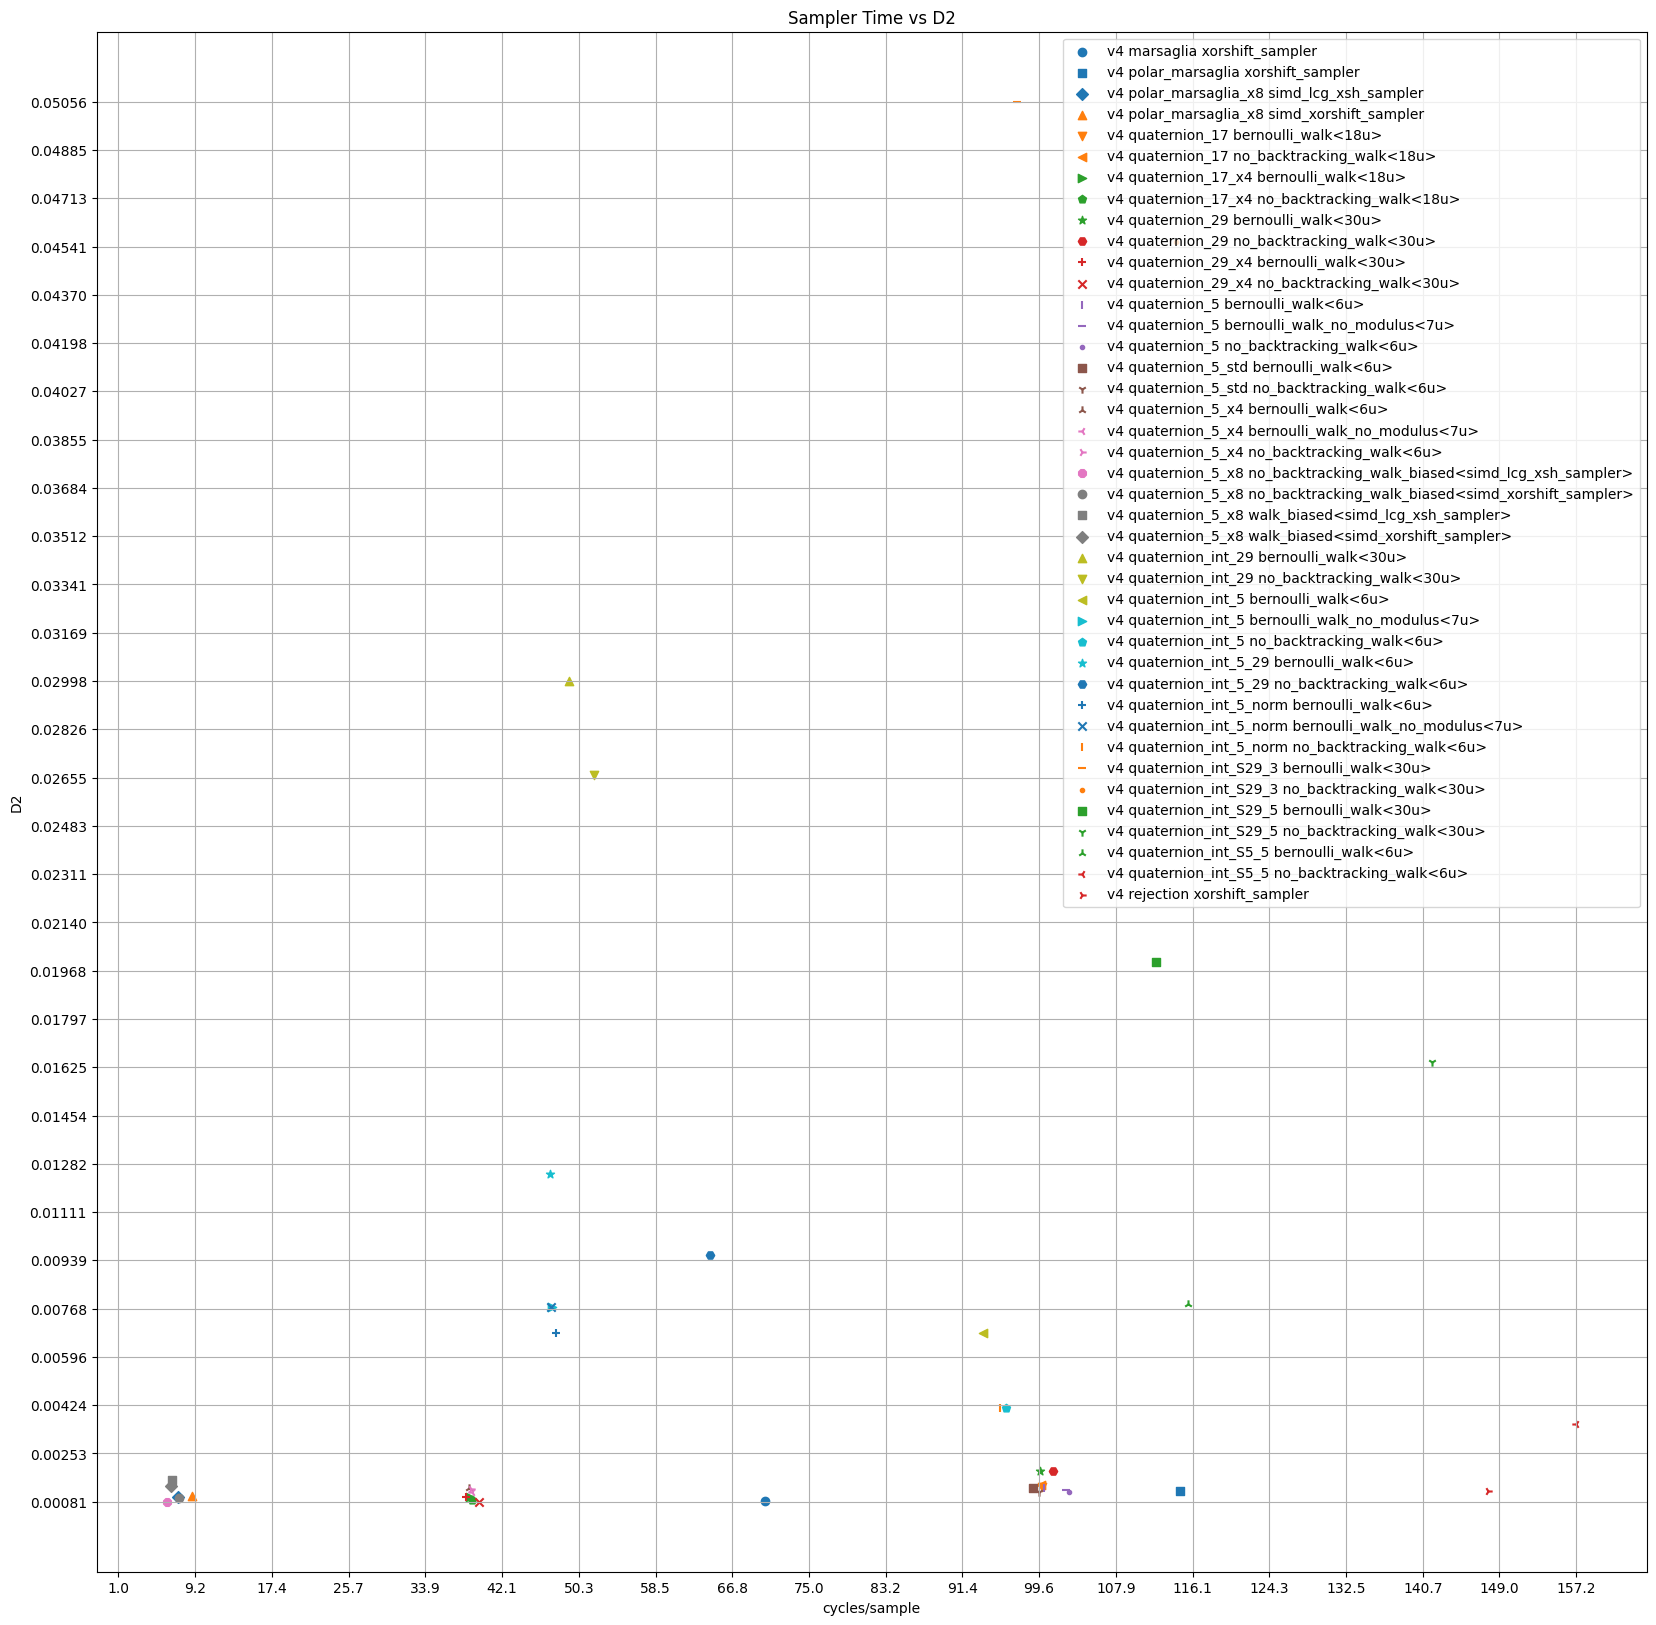

v4 quaternion_5_x8 no_backtracking_walk_biased<simd_lcg_xsh_sampler> 6.215611267089844 0.00081366004
v4 quaternion_5_x8 walk_biased<simd_xorshift_sampler> 6.635302734375 0.001367827
v4 quaternion_5_x8 walk_biased<simd_lcg_xsh_sampler> 6.757786560058594 0.0016024724
v4 polar_marsaglia_x8 simd_lcg_xsh_sampler 7.354067840576172 0.00097193534
v4 quaternion_5_x8 no_backtracking_walk_biased<simd_xorshift_sampler> 7.507424926757812 0.000955011
v4 polar_marsaglia_x8 simd_xorshift_sampler 8.842490234375 0.0010203584
v4 quaternion_29_x4 bernoulli_walk<30u> 38.25782089233398 0.00097373856
v4 quaternion_5_x4 bernoulli_walk<6u> 38.59341201782227 0.001285437
v4 quaternion_17_x4 bernoulli_walk<18u> 38.70101470947266 0.0009951224
v4 quaternion_5_x4 no_backtracking_walk<6u> 38.79724807739258 0.0012515917
v4 quaternion_17_x4 no_backtracking_walk<18u> 38.87829437255859 0.00085858424
v4 quaternion_5_x4 bernoulli_walk_no_modulus<7u> 38.926476287841794 0.001146397
v4 quaternion_29_x4 no_backtracking_walk<30

In [58]:

plot_scatter(analyze_timing(all_v4_timings_sampler), "Sampler Time vs D2", "cycles/sample", "D2")
sorted_sampler_timings = sorted(analyze_timing(all_v4_timings_sampler), key=lambda x: x[1])
for s in sorted_sampler_timings:
    print(s[0], s[1], s[2])

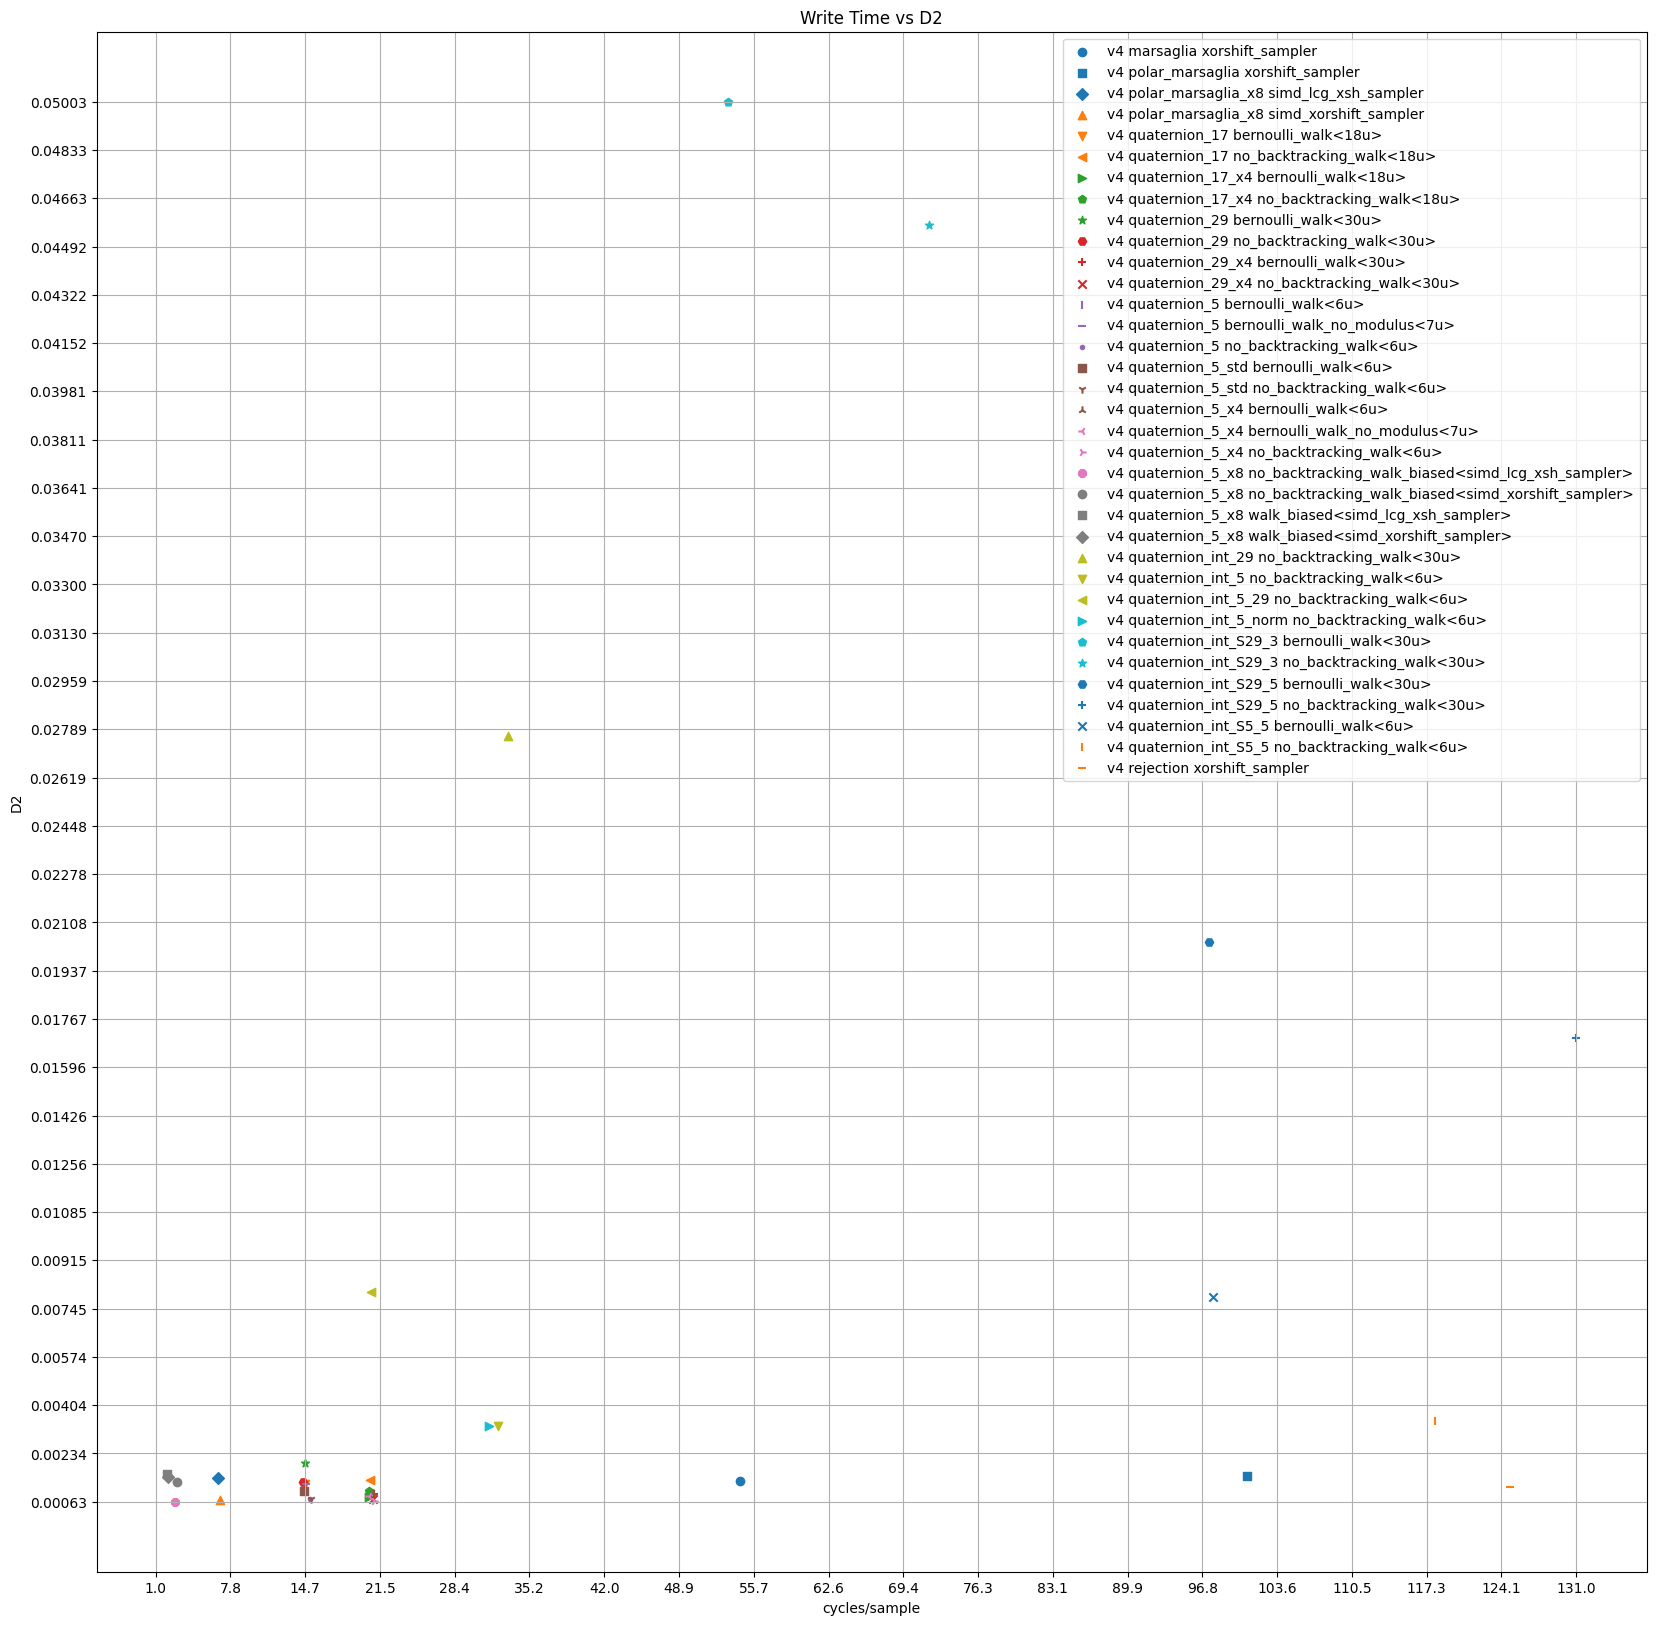

v4 quaternion_5_x8 walk_biased<simd_lcg_xsh_sampler> 2.031227874755859
v4 quaternion_5_x8 walk_biased<simd_xorshift_sampler> 2.142842102050781
v4 quaternion_5_x8 no_backtracking_walk_biased<simd_lcg_xsh_sampler> 2.779541015625
v4 quaternion_5_x8 no_backtracking_walk_biased<simd_xorshift_sampler> 2.931935119628906
v4 polar_marsaglia_x8 simd_lcg_xsh_sampler 6.731117248535156
v4 polar_marsaglia_x8 simd_xorshift_sampler 6.887624359130859
v4 quaternion_29 no_backtracking_walk<30u> 14.450777435302735
v4 quaternion_5_std bernoulli_walk<6u> 14.541002655029297
v4 quaternion_17 bernoulli_walk<18u> 14.640621185302734
v4 quaternion_29 bernoulli_walk<30u> 14.665003967285156
v4 quaternion_5 bernoulli_walk<6u> 14.677397918701171
v4 quaternion_5 bernoulli_walk_no_modulus<7u> 14.715843200683594
v4 quaternion_5 no_backtracking_walk<6u> 15.163872528076173
v4 quaternion_5_std no_backtracking_walk<6u> 15.178292083740235
v4 quaternion_17_x4 bernoulli_walk<18u> 20.473626708984376
v4 quaternion_17_x4 no_backt

In [41]:
plot_scatter(analyze_timing(all_v4_timings_write),   "Write Time vs D2", "cycles/sample", "D2")
sorted_write_timings= sorted(analyze_timing(all_v4_timings_write), key=lambda x: x[1])
for s in sorted_write_timings:
    print(s[0], s[1])

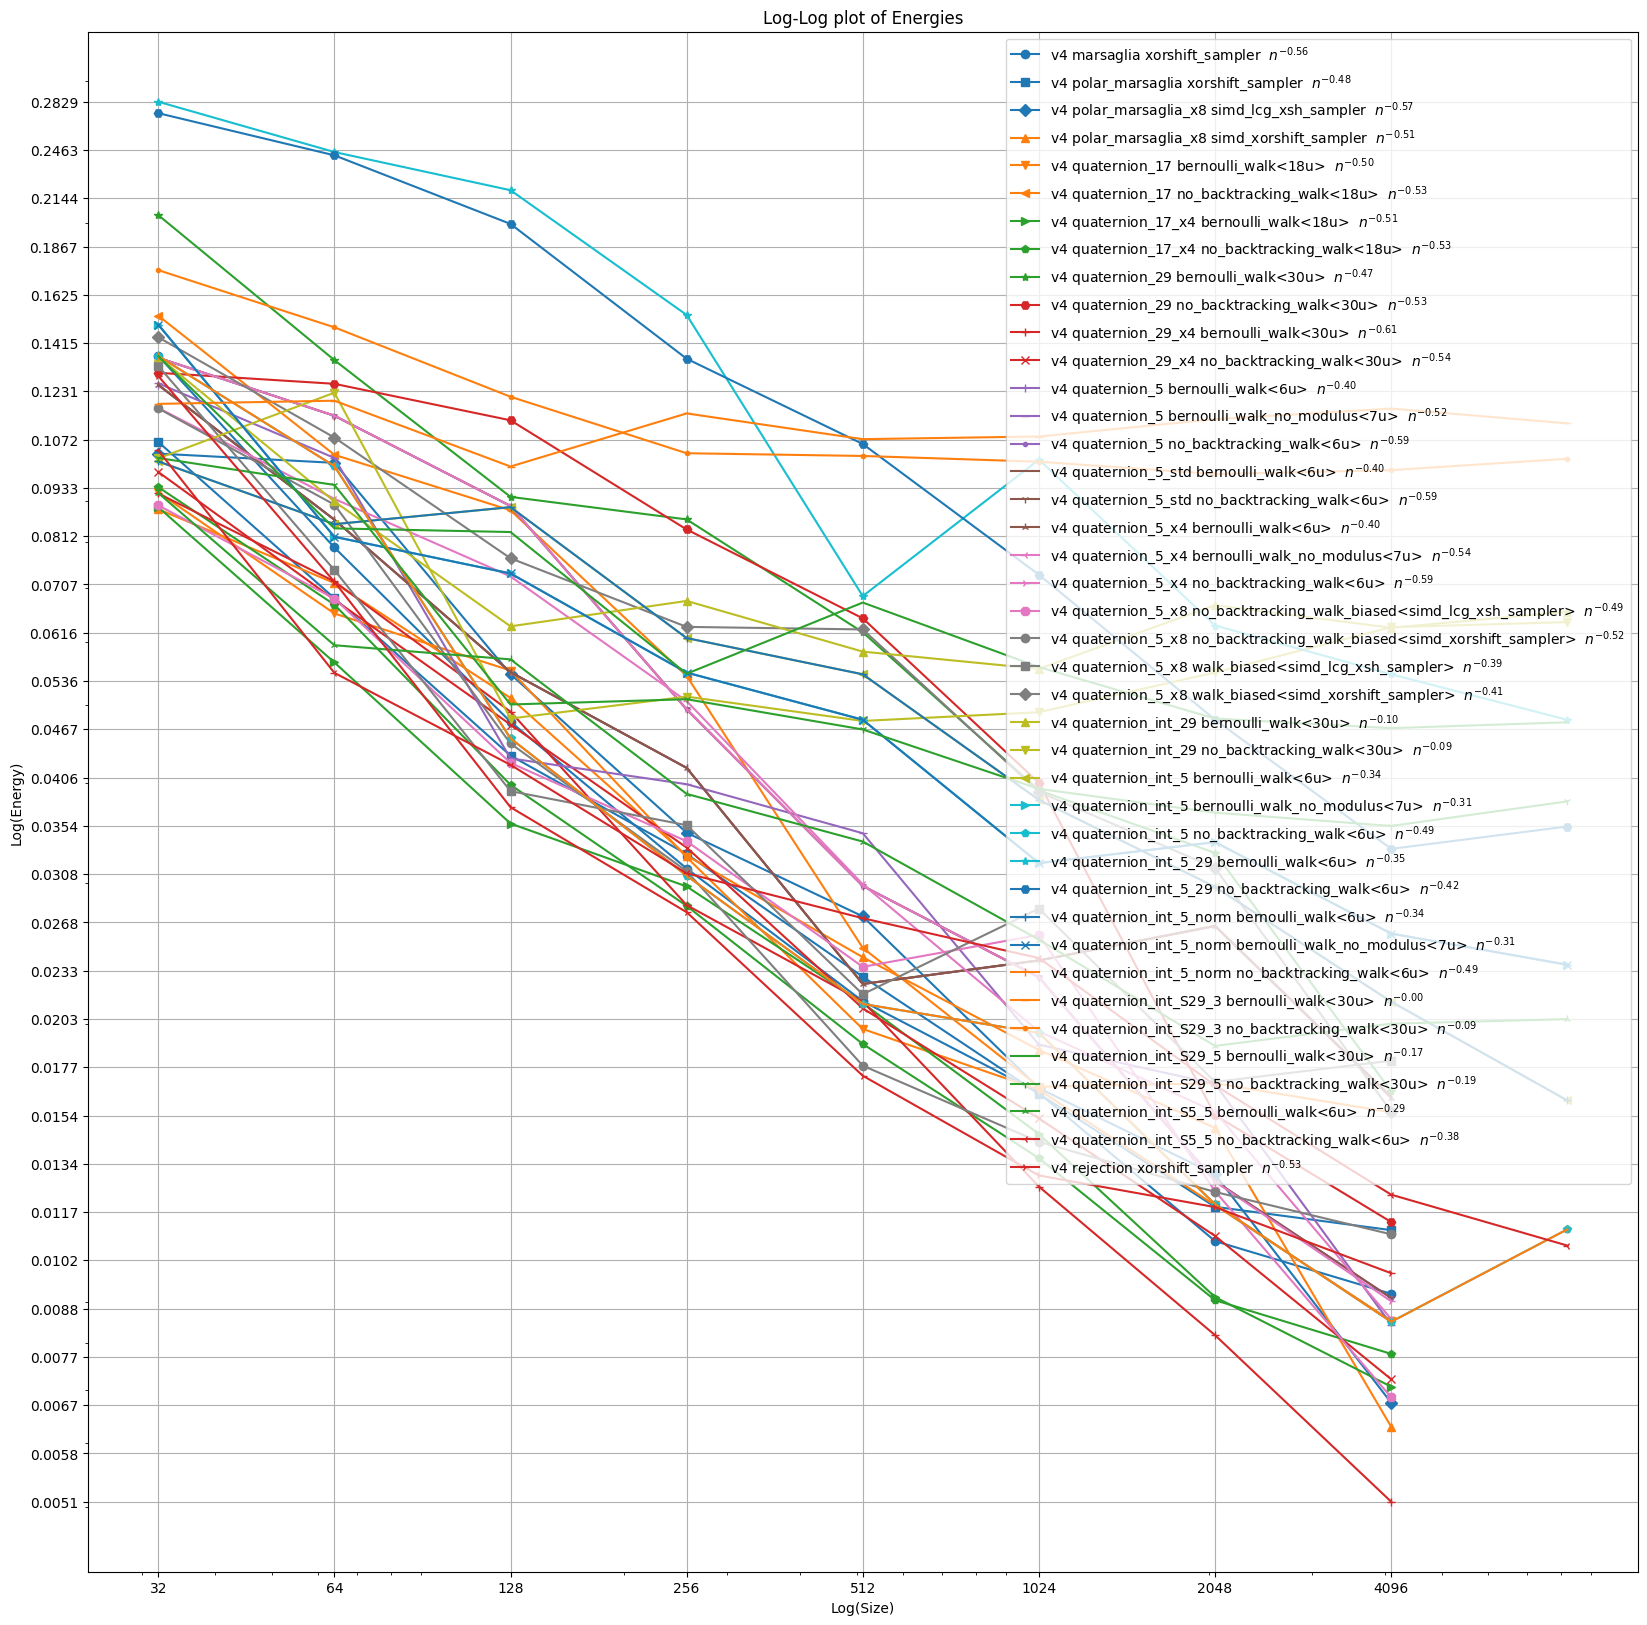

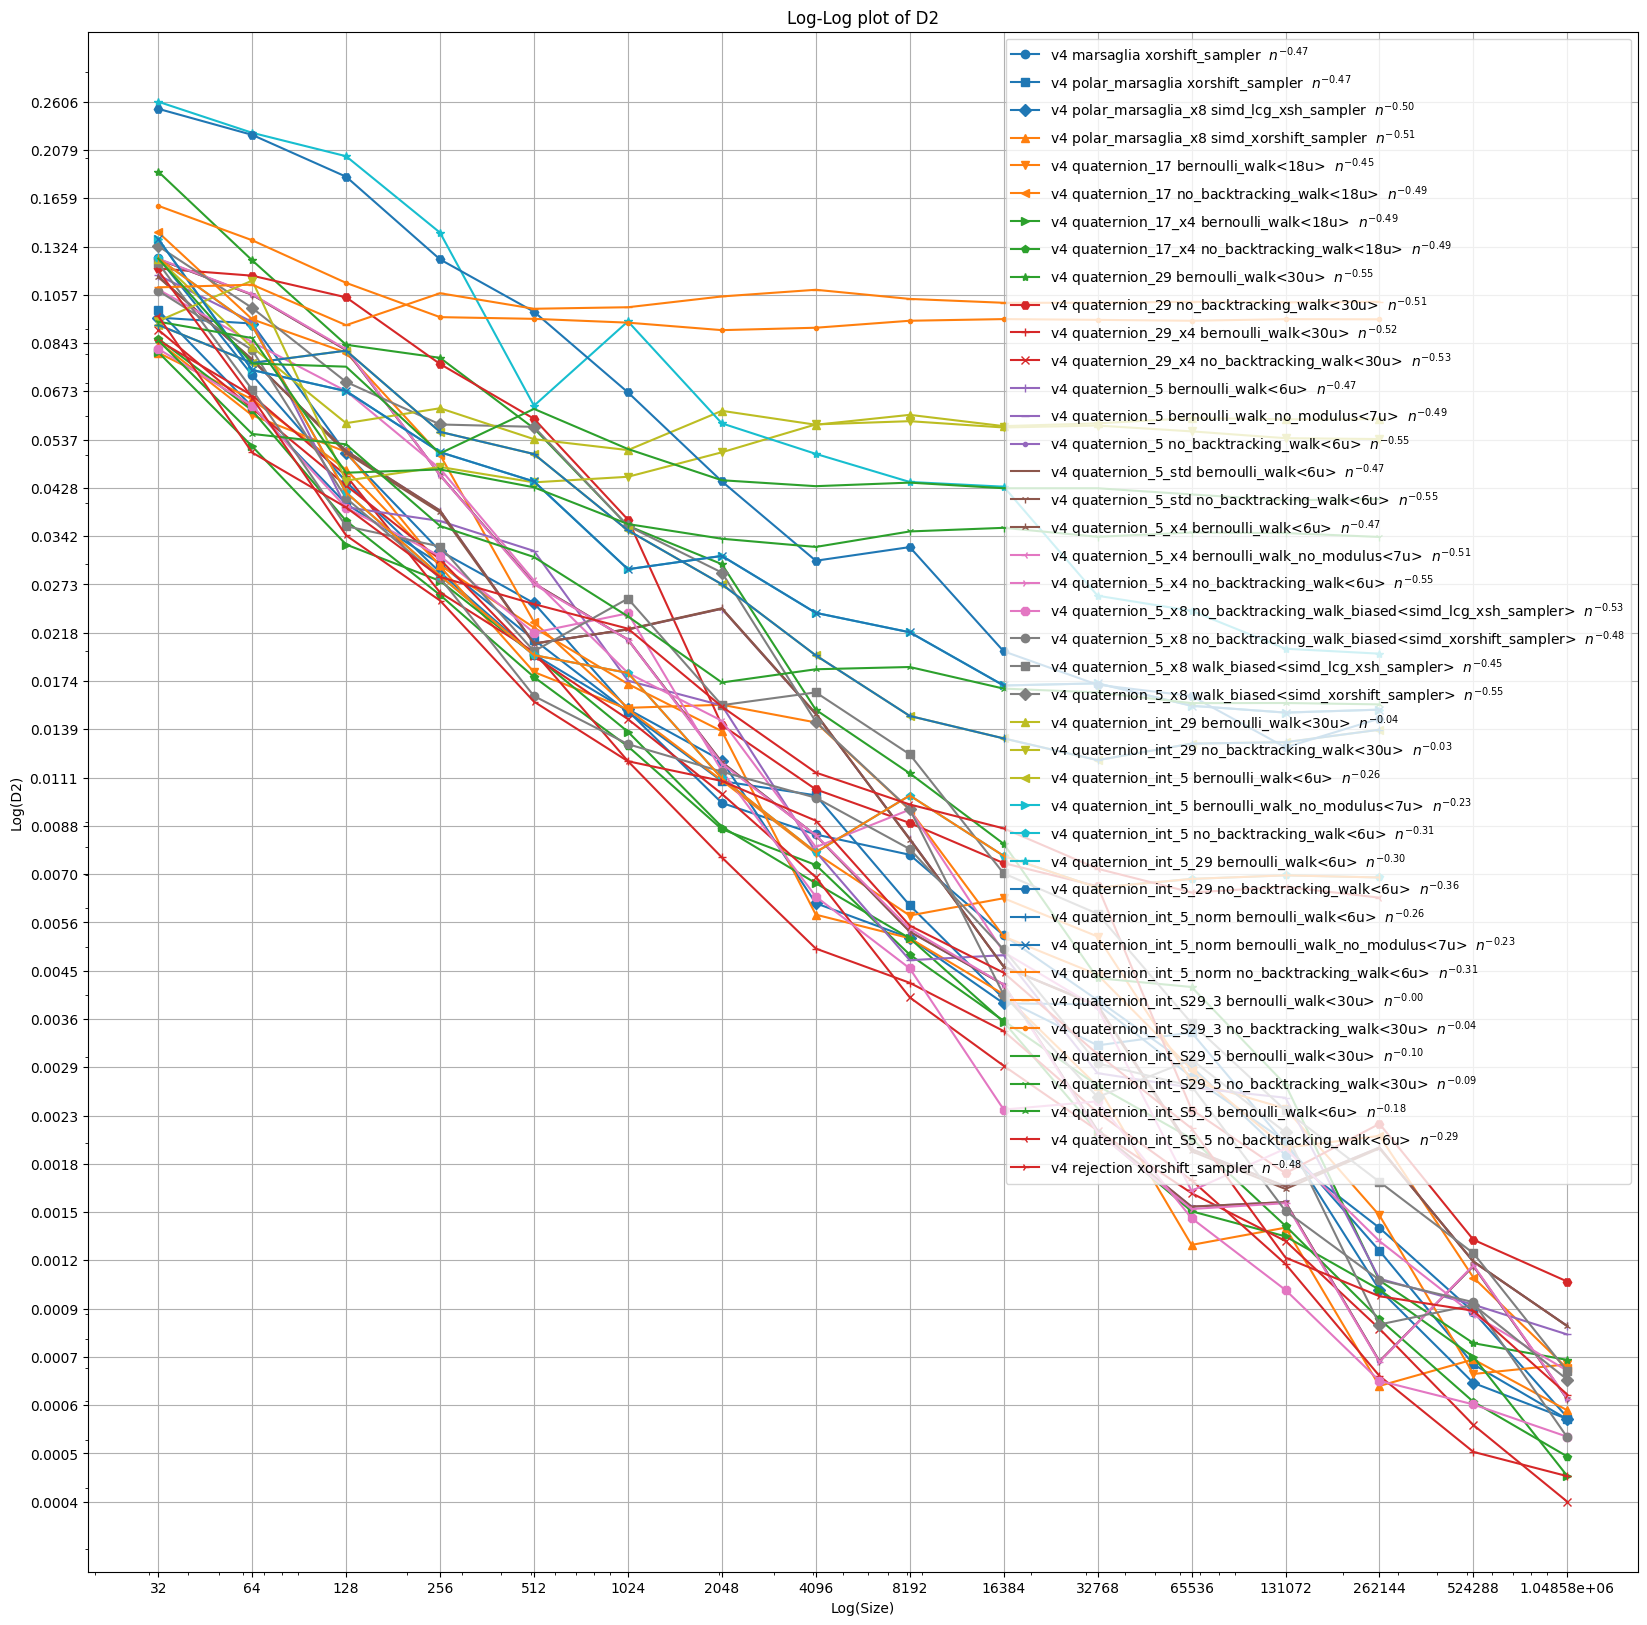

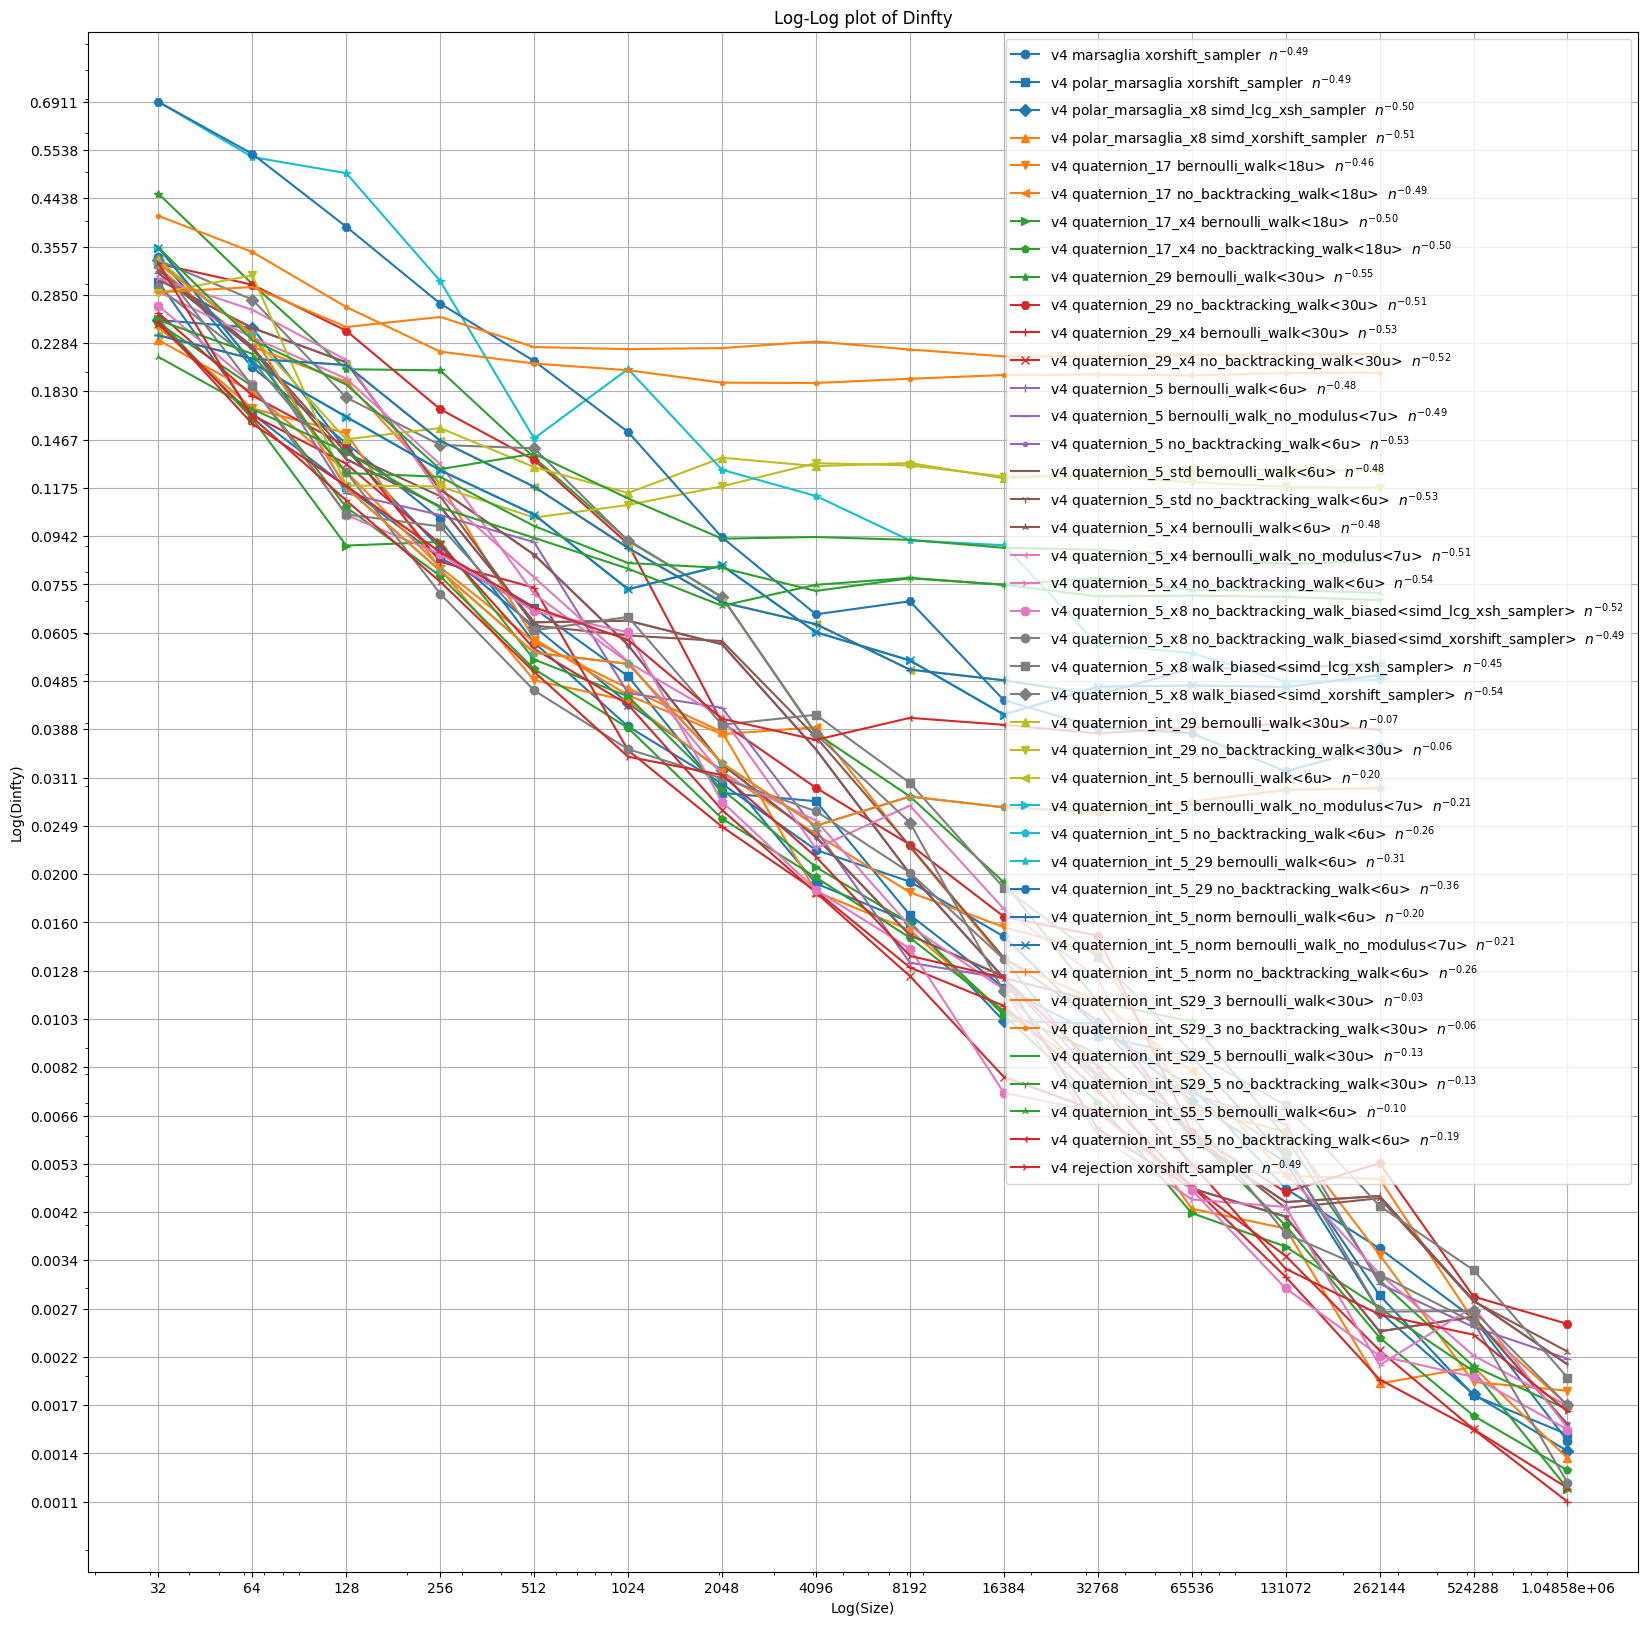

In [63]:
plot_log_log(all_v4_energies, "Energies", "Log(Size)", "Log(Energy)")
plot_log_log(all_v4_d2, "D2", "Log(Size)", "Log(D2)")
plot_log_log(all_v4_dinfty, "Dinfty", "Log(Size)", "Log(Dinfty)")


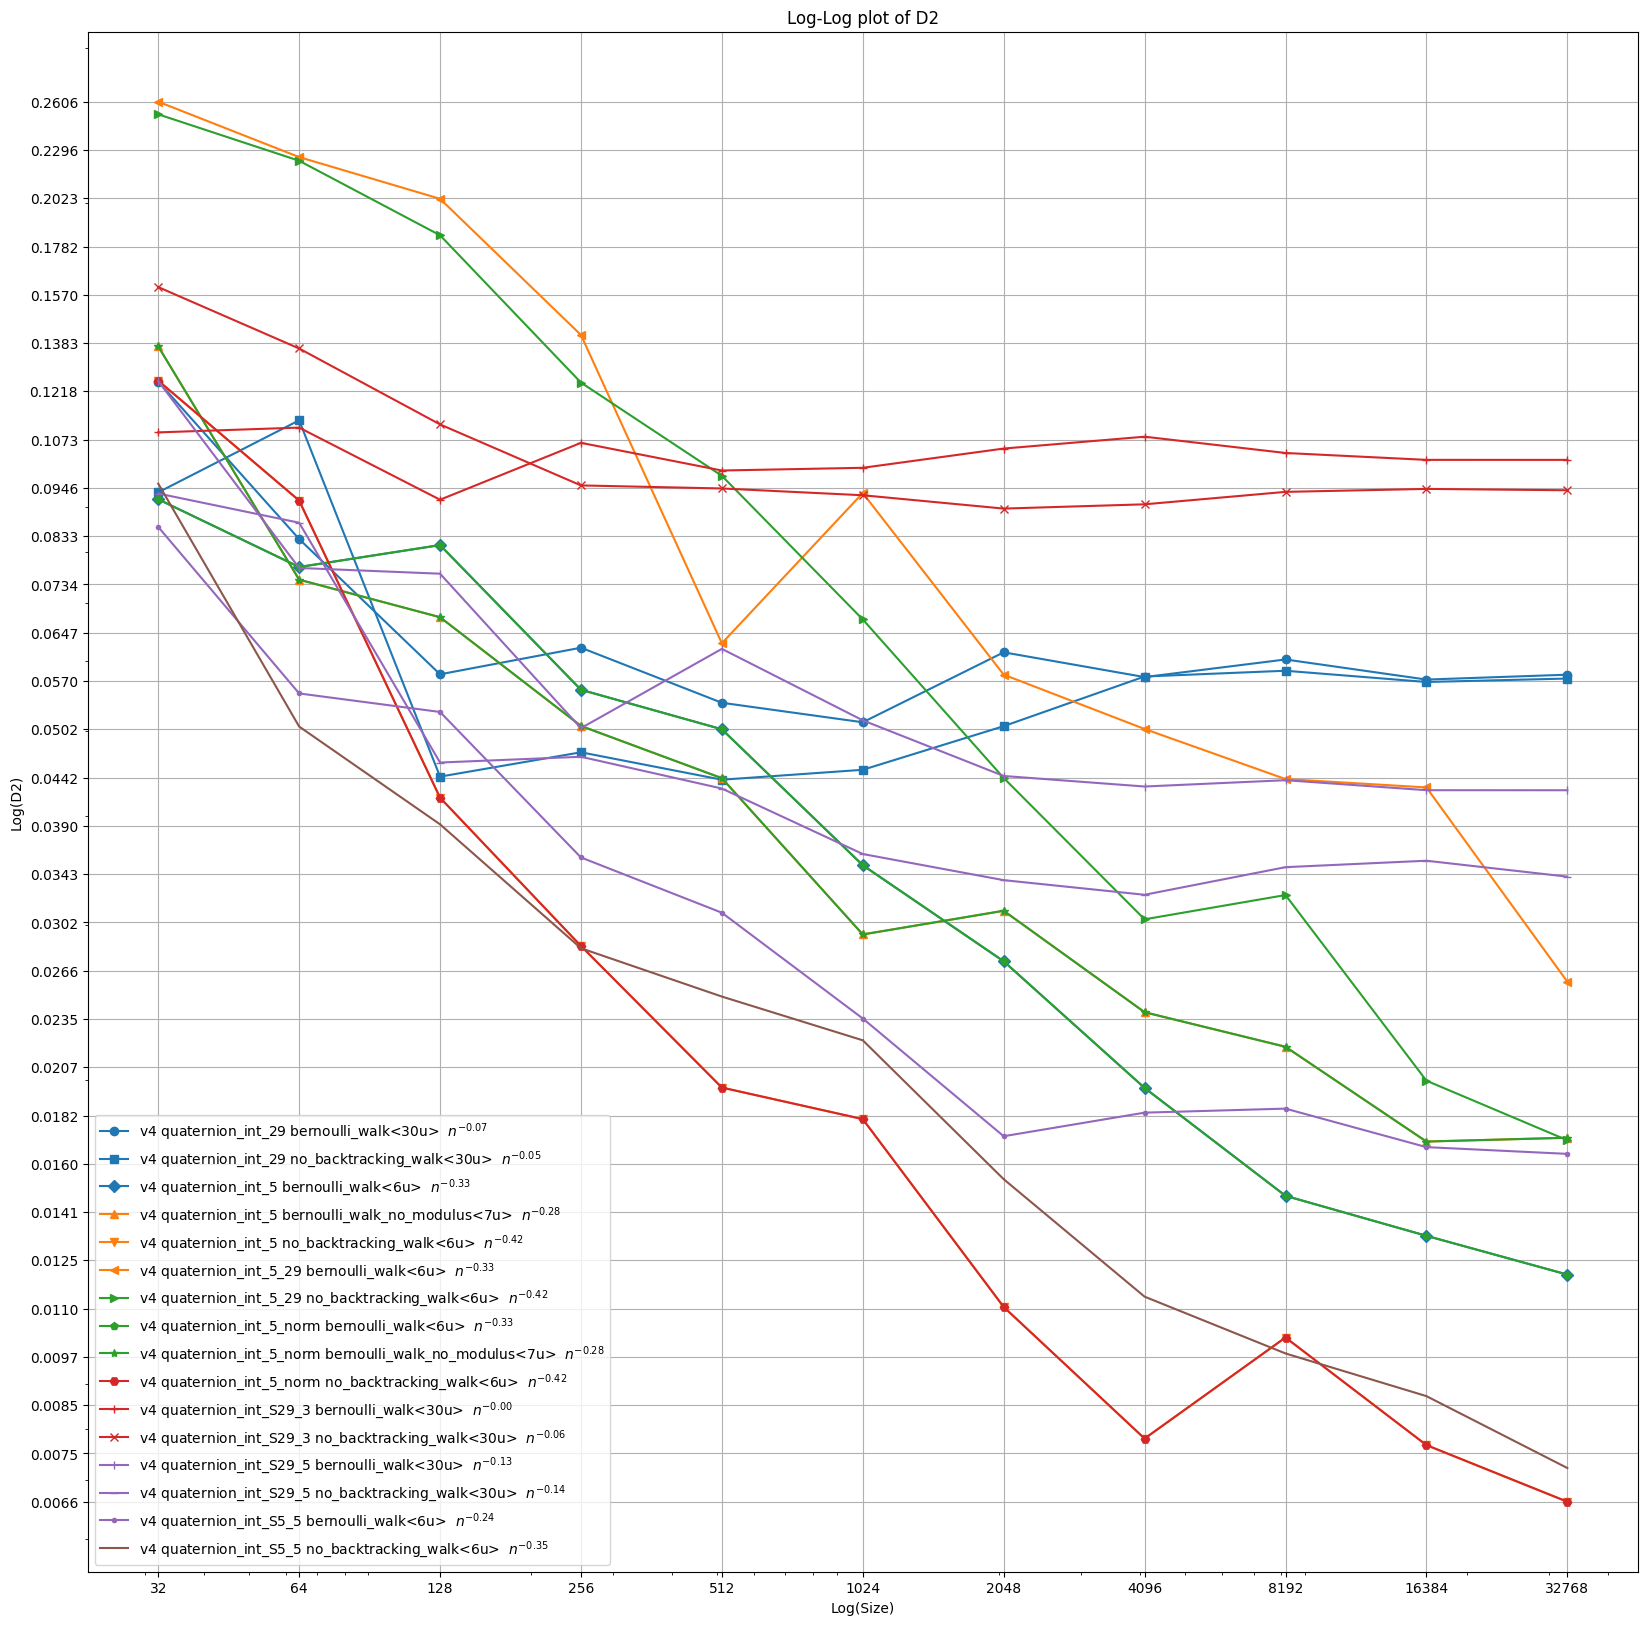

In [64]:
int_d1= [[x[0], x[1][:11], x[2][:11]] for x in all_v4_d2 if 'int' in x[0]]
plot_log_log(int_d1, "D2", "Log(Size)", "Log(D2)")


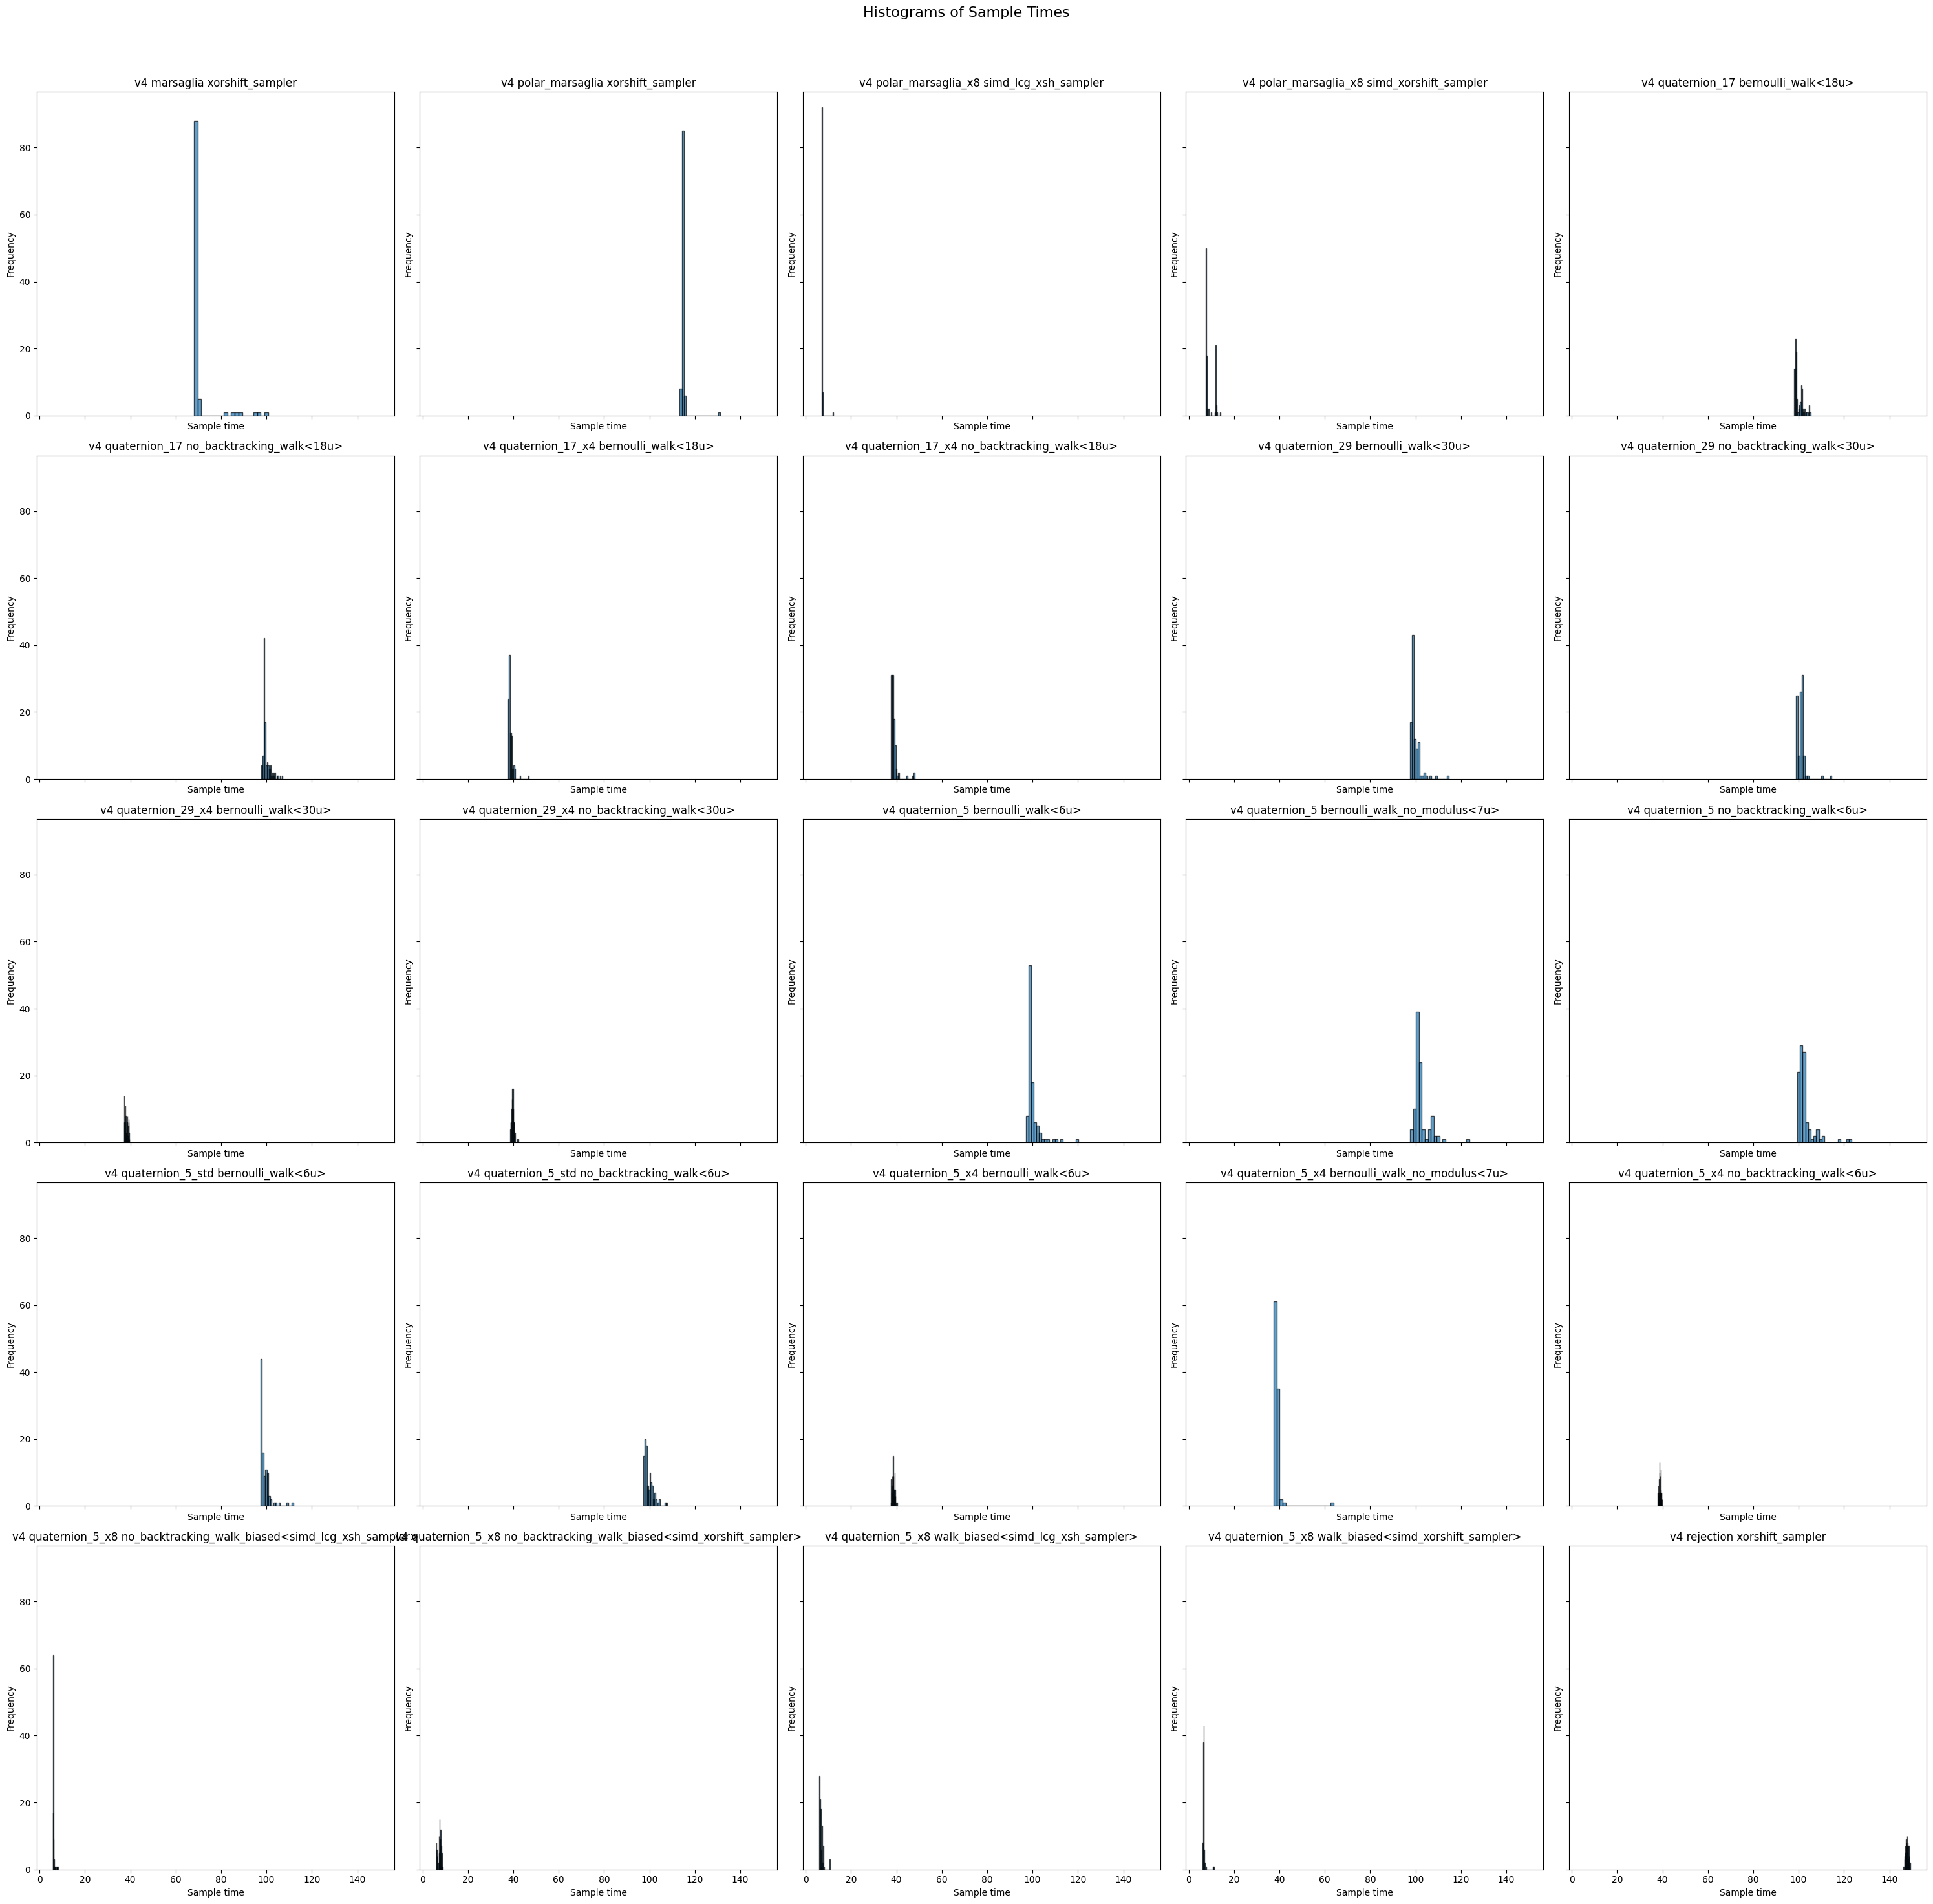

In [150]:

# Determine the number of rows and columns for the grid based on the number of data points
num_data_points = len(all_v4_timings_sampler)
num_rows = int(np.ceil(np.sqrt(num_data_points)))
num_cols = int(np.ceil(num_data_points / num_rows))

# Create a figure and a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 30), sharex=True, sharey=True)
fig.suptitle('Histograms of Sample Times', fontsize=16)

# Flatten the 2D array of subplots to simplify indexing
axes = np.array(axes).flatten()

# Plot histograms for each data point
for i, [label, times, _, n] in enumerate(all_v4_timings_sampler):
    ax = axes[i]
    
    # Plot histogram
    times_normalized= np.array(times, dtype=float) / n 
 
    ax.hist(times_normalized, bins=20, edgecolor='black', alpha=0.7)

    # Set labels and title for each subplot
    ax.set_title(label)
    ax.set_xlabel('Sample time')
    ax.set_ylabel('Frequency')

# Adjust layout to prevent overlap of titles
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()

In [65]:
compute_timings = load_data("compute_timings", load_timing)
label_descriptions = {
    1: "Marsaglia PCG",
    2: "Marsaglia PCG3",
    18: "Sphere Walk S5_4",
    19: "Random Walk S5_4",
    20: "Super-Fibonacci",
    30: "Non-uniform Rejection"
}

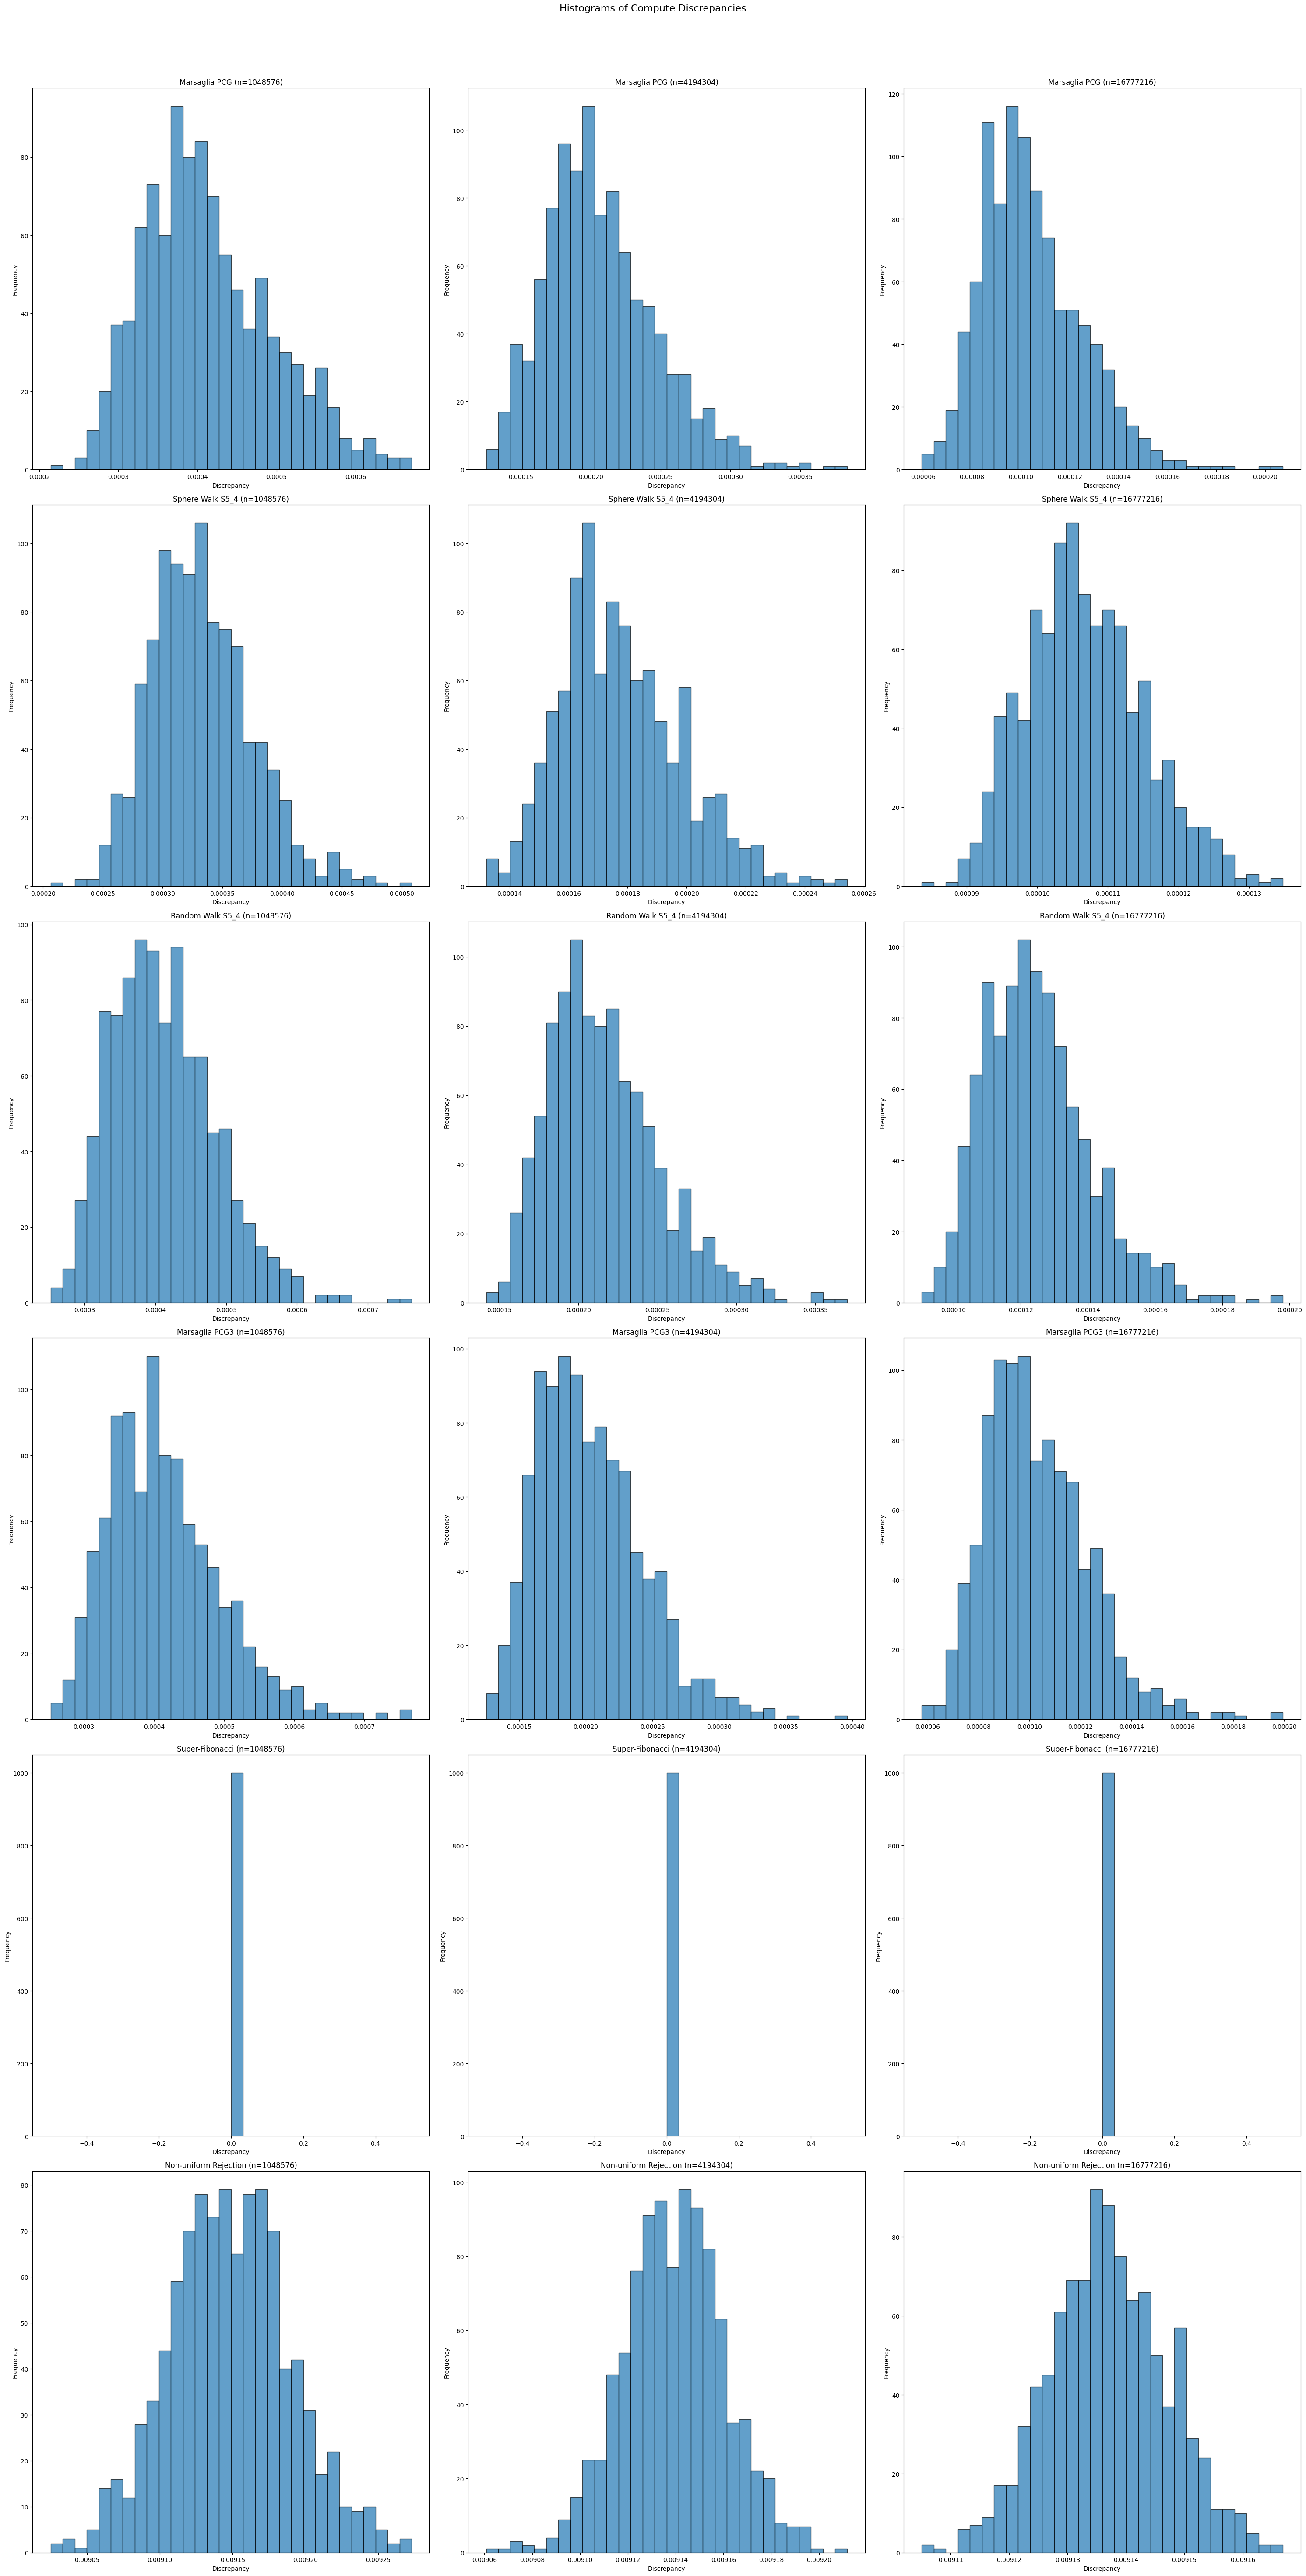

In [66]:
compute_timings.sort(key=lambda x: (x[0], x[3]))
num_data_points = len(compute_timings)
num_rows = 6
num_cols = int(np.ceil(num_data_points / num_rows))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 60), sharex=False, sharey=False)
fig.suptitle('Histograms of Compute Discrepancies ', fontsize=16)
axes = np.array(axes).flatten()
for i, [label, times, disc, n] in enumerate(compute_timings):
    ax = axes[i]
    ax.hist(disc, bins=30, edgecolor='black', alpha=0.7)

    textual_label = label_descriptions.get(int(label), f"Unknown Label {label}")
    ax.set_title(f'{textual_label} (n={n})') 
    ax.set_xlabel('Discrepancy')
    ax.set_ylabel('Frequency')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()